## Making light curves from STIS time-tag data.

### David Wilson 
djwilson394@gmail.com

Hello! There are many ways to extract light curves from STIS data. This is my prefered way, as you get nice time-series, flux calibrated spectra as a byproduct. This notebook contains a step-by-step guide to extract one light curve, followed by thoughts on where to go from there. You'll need a python 3 setup with numpy, matplotlib, astropy and stistools (https://stistools.readthedocs.io/en/latest/gettingstarted.html).  

As of 20200622, this notebook only deals with non-echelle STIS MAMA data. Additional guides for echelle data and maybe COS might be added in the future, or might not.  

Modified from a turtorial on 20210405, so some of the text might not make sense...

In [2]:
#import the packages we need. 

import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
import stistools
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii
from astropy.units import cds
cds.enable()



%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


First define some paths pointing to where the data is, and the output. For this example, I retrieved the dataset O5B688040 from MAST. https://archive.stsci.edu/cgi-bin/mastpreview?mission=hst&dataid=O5B688040. You'll want to tick all of the boxes for what data you want on the retrieval page (calibrated, uncalibrated etc.).

In [3]:
datapath = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
outpath = 'lc_output/'

First let's have a look at the spectrum. Here there's only one dataset, but the whole notebook is written to work on multiple datasets at once if needed.

In [4]:
x1ds = glob.glob('{}*x1d.fits'.format(datapath))
x1ds

['/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_x1d.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_x1d.fits']

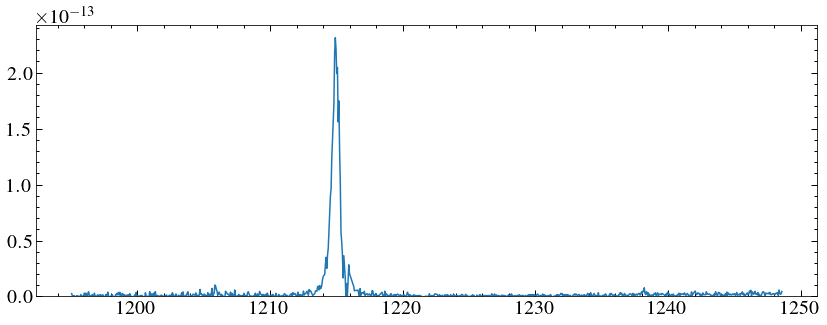

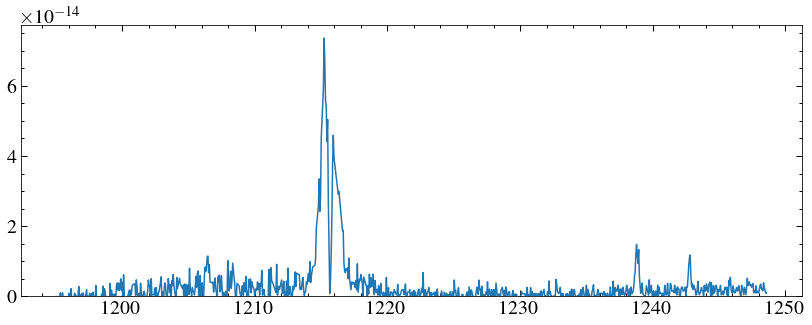

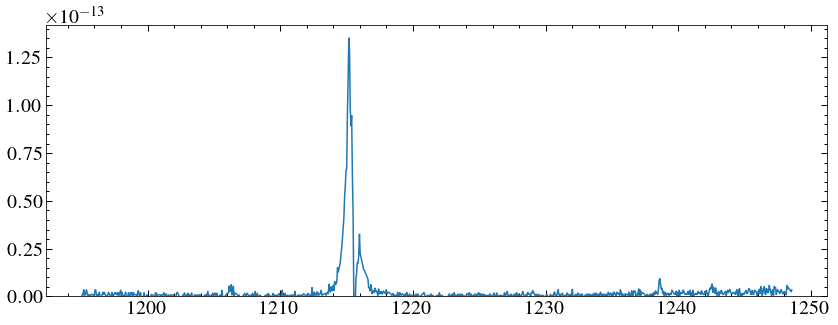

In [5]:

for x in x1ds:
    data = fits.getdata(x,1)[0]
    plt.plot(data['WAVELENGTH'][data['DQ']==0], data['FLUX'][data['DQ']==0])
    plt.ylim(0.0)
    plt.show()

The process is as follows: First we use the intagg tool to split the "tag" file, which contains the time and location of every event picked up by the detector, into bins of whatever time step we want our light curve to be. Then, we use calstis to extract spectra from each of the binned tag files. Finally, we integrate ranges of those spectra to make a light curve. 

In [6]:
#there should be one tag per x1d file. If you have more tags than x1ds, that means a spectrum has failed to extract. 
#Fixing that is beyond the scope of this notebook, but I'm happy to help if you need advice.
tags = glob.glob('{}*tag.fits'.format(datapath))
tags

['/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua1010_tag.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua2010_tag.fits',
 '/media/david/5tb_storage1/eg_uma/hst/stis/data/oehua4010_tag.fits']

The most important decision is what time step to use. This will depend on what you want to do with the light curve, and whether you want the spectra to be usable. For this demo I tried 10s and 100s light curves. I'm showing the 100s here as it takes a shorter time to run, but 10s looks like the better choice for picking out the pulsations of GW Librae.  

Now run intagg on each tagfile. This will make a new "raw" file with multiple extensions, where each extension after the first contains the events for one time bin. Note that stistools doens't like makeing repeat files, so if you want to re-run this you need to remove all new raw files, x1ds files etc from the output directory. https://stistools.readthedocs.io/en/latest/inttag.html

In [18]:
t_bin = 675 #in seconds

for tag in tags:
    rootname = fits.getheader(tag)['ROOTNAME'] #find the rootname of the tagfile to name the output file
    exptime = fits.getheader(tag)['TEXPTIME'] 
    n_bins = int(exptime/t_bin) #use the exposure time to tell inttag how many time bins there will be
    print('n_bins = {}'.format(n_bins) )
    outfile = '{}{}_{}s_raw.fits'.format(outpath, rootname, t_bin) #build the file path and file name of the output
    stistools.inttag.inttag(tag, outfile, rcount = n_bins, increment = t_bin, verbose=False) #change verbose to true to diagnose problems

n_bins = 2
n_bins = 2
n_bins = 2


In [19]:
#and here are the new raw files
raws = glob.glob('{}*{}*raw.fits'.format(outpath, t_bin))
raws

['lc_output/oehua2010_675s_raw.fits',
 'lc_output/oehua4010_675s_raw.fits',
 'lc_output/oehua1010_675s_raw.fits']

If you downloaded all of the "used reference files" into the same directory as the original data, set oref to point there. If you're using a local caldb, point it to those instead. 

In [20]:
os.environ['oref'] = datapath 

Calstis will now take the new raw file and extract a spectrum from each of the extensions, giving you time-series spectra.https://stistools.readthedocs.io/en/latest/calstis.html

In [21]:
for raw in raws:
    rootname = fits.getheader(raw)['ROOTNAME'] 
    outname = '{}{}_{}s'.format(outpath, rootname, t_bin) #build the file path and file name of the output
    stistools.calstis.calstis(raw, outroot = outname, wavecal='{}{}_wav.fits'.format(datapath, rootname), trailer='trls/{}_{}s_extract.trl'.format(rootname,t_bin))

Now you should have one new x1d file per raw file. If not, consult the trl files and the STIS data handbook for what went wrong https://hst-docs.stsci.edu/stisdhb. 

In [22]:
new_x1ds = glob.glob('{}*{}s*x1d.fits'.format(outpath, t_bin))
new_x1ds

['lc_output/oehua4010_675s_x1d.fits',
 'lc_output/oehua1010_675s_x1d.fits',
 'lc_output/oehua2010_675s_x1d.fits']

Let's have a look at the spectra and see what we can see. The new x1d file, as with the raw files, will contain multiple extensions where every extension after the first contains a spectrum extracted from one timebin in the raw file.

oehua4010


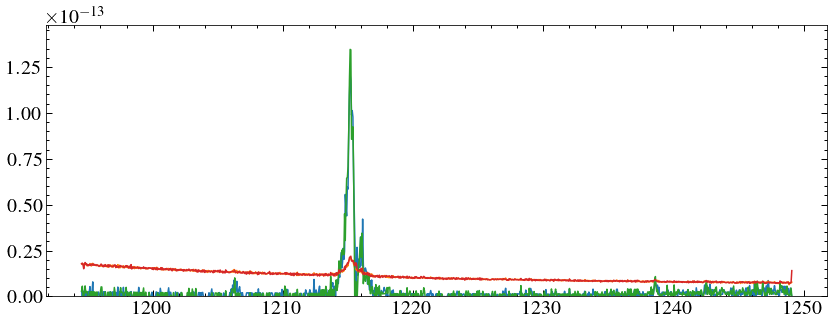

oehua2010


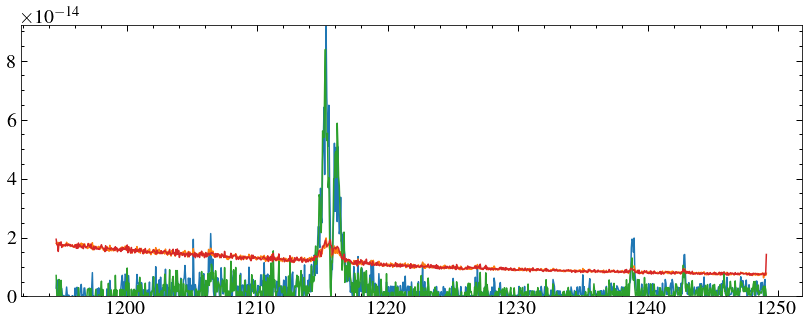

oehua1010


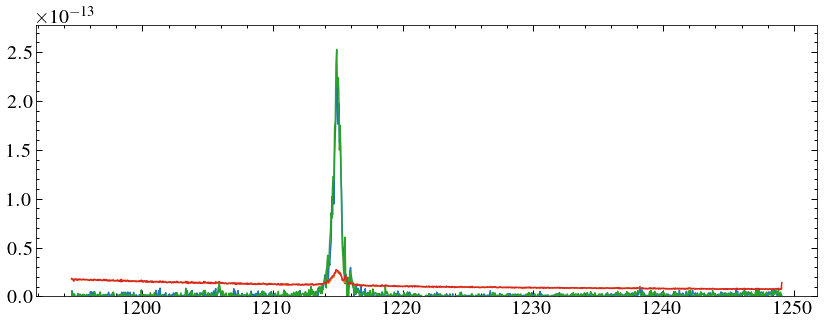

In [12]:
for x in new_x1ds:
    hdul = fits.open(x)
    print(hdul[0].header['ROOTNAME'])
    for ext in hdul[1::]: #spectra in every extension after the first
        data = ext.data[0]
        plt.plot(data['WAVELENGTH'], data['FLUX'])
        plt.plot(data['WAVELENGTH'], data['ERROR'])
        plt.ylim(0, 1.1*max(data['FLUX']))
        #plt.show()
    hdul.close()
    plt.show()

Now decide what you want a light curve of! It could be the whole spectrum, it could be just some emission lines, up to you. Here the spectra look pretty noisy after 1300A, so I'm going to thow everything before that away for this example. The next box takes the spectra, cuts them down the the range in "band", then integrates the spectrum to give you your flux and error.  

As written this returns a light curve in counts/s. If you want it flux calibrated, returning erg/s/cm2/A, uncomment the second line starting w, f, e etc. This comes with a factor ~2 decrease in S/N, so only do it if you really care about absolute flux.

oehua4010


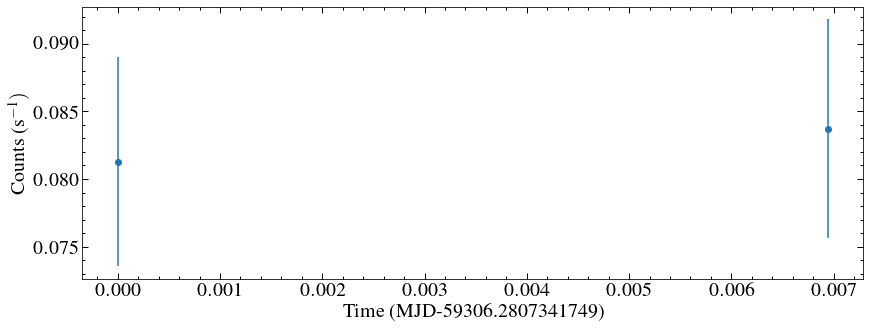

oehua2010


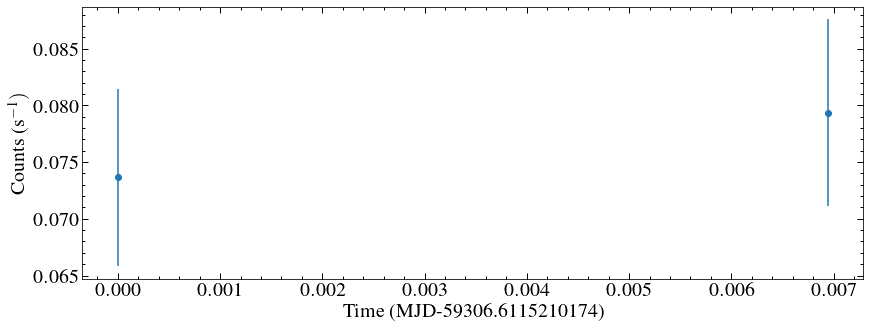

oehua1010


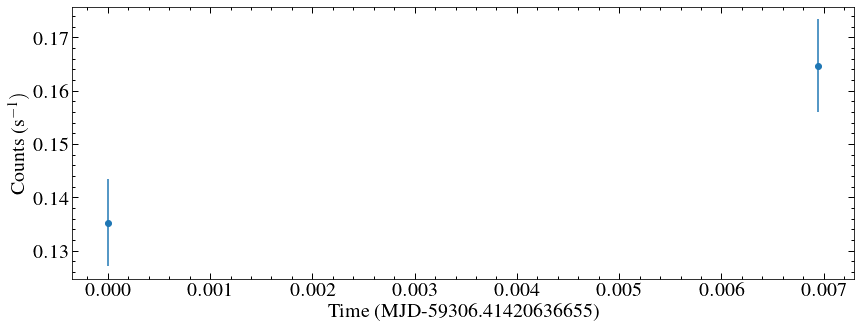

In [13]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1

band = [1210, 1220] #pick the wavelength range to integrate.
for x in new_x1ds:
    time = [] #arrays to put the light curve in
    flux = []
    error = []
    hdul = fits.open(x)
    rootname = hdul[0].header['ROOTNAME']
    print(rootname)
    for ext in hdul[1::]:
        data = ext.data[0]
        hdr = ext.header
        ti = (hdr['EXPSTART']+hdr['EXPEND'])/2 #work out the mid-point of the time bin and add it to the time array
        time.append(ti)
        w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
        #w, f, e , dq = (data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']) #uncomment this line for flux-calibrated light curves
        
        
        w0, w1 = wavelength_edges(w) 
        mask  = (w > band[0]) & (w < band[1]) & (dq == 0)
        w0, w1, f, e = w0[mask], w1[mask], f[mask], e[mask]
        fi = np.sum(f*(w1-w0))
        ei = (np.sum(e**2 * (w1-w0)**2))**0.5
        flux.append(fi)
        error.append(ei)
        
    
    hdul.close()    
    time, flux, error = np.array(time), np.array(flux), np.array(error)
    t0 = time[0]
    plt.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
    plt.ylabel('Counts (s$^{-1})$')
    plt.xlabel('Time (MJD-{})'.format(t0))
    plt.show()    
    
    save_data = Table([time*cds.MJD, flux/u.s, error/u.s], names = ['TIME', 'FLUX', 'ERROR'])
    ascii.write(save_data, '{}{}_{}s_lc.ecsv'.format(outpath, rootname, t_bin), format = 'ecsv', overwrite=True)
        

Looks great. Maybe some structure there? Let's take a quick look using lightkurve https://docs.lightkurve.org/index.html.

In [14]:
"""import lightkurve as lk
lc = lk.LightCurve(time=time, flux=flux, flux_err=error).remove_outliers(sigma=5)
pg = lc.to_periodogram(oversample_factor=10,minimum_period=2*t_bin*u.second, maximum_period=1*u.hour)
plt.plot(pg.period.to(u.s), pg.power)
plt.xlabel('Period (s)')
plt.ylabel('Counts (s$^{-1})$')


print(pg.period_at_max_power.to(u.s))"""

"import lightkurve as lk\nlc = lk.LightCurve(time=time, flux=flux, flux_err=error).remove_outliers(sigma=5)\npg = lc.to_periodogram(oversample_factor=10,minimum_period=2*t_bin*u.second, maximum_period=1*u.hour)\nplt.plot(pg.period.to(u.s), pg.power)\nplt.xlabel('Period (s)')\nplt.ylabel('Counts (s$^{-1})$')\n\n\nprint(pg.period_at_max_power.to(u.s))"

https://ui.adsabs.harvard.edu/abs/2002ApJ...575L..79S/abstract reports pulsation periods of 646, 376, and 237s. Looks like we've found them, or close enough for a 100s light curve! Finally, let's save our light curve to a file. I like the ecsv format but you can use what you want. If you're using more than one dataset then you should put this in the loop where you integrate the light curve. 

In [15]:
"""from astropy.table import Table
from astropy.io import ascii
from astropy.units import cds
cds.enable()

save_data = Table([time*cds.MJD, flux/u.s, error/u.s], names = ['TIME', 'FLUX', 'ERROR'])
ascii.write(save_data, '{}_{}s_lc.ecsv'.format(rootname, t_bin), format = 'ecsv', overwrite=True)"""

"from astropy.table import Table\nfrom astropy.io import ascii\nfrom astropy.units import cds\ncds.enable()\n\nsave_data = Table([time*cds.MJD, flux/u.s, error/u.s], names = ['TIME', 'FLUX', 'ERROR'])\nascii.write(save_data, '{}_{}s_lc.ecsv'.format(rootname, t_bin), format = 'ecsv', overwrite=True)"

## What to do next  
I suggest re-writing the above into a function or two, taking as inputs the time bin and waveband required. Then re-run this with a 10s time bin and see if you can refine the periods.  

For very short time bins calstis might not find the spectrum. In that case I suggest binning the x2d file and subtracting a background flux using the regions found in the original x1d file header.   
 
Finally, BEWARE BREATHING. STIS light curves can be heavily affected by the "breathing" of the telescope as it moves around the Earth. If your light curve contains a signal with period $\approx$ 96 miniutes, it's proably breathing. The exact period for each observation can be found in the "spt" file, where the header keyword "HSTHHORB" is half the orbital period in seconds. Dividing out a sine fit with period fixed to this value should remove any breathing effects.     
